(<Figure size 1700x500 with 1 Axes>, <Axes: >)

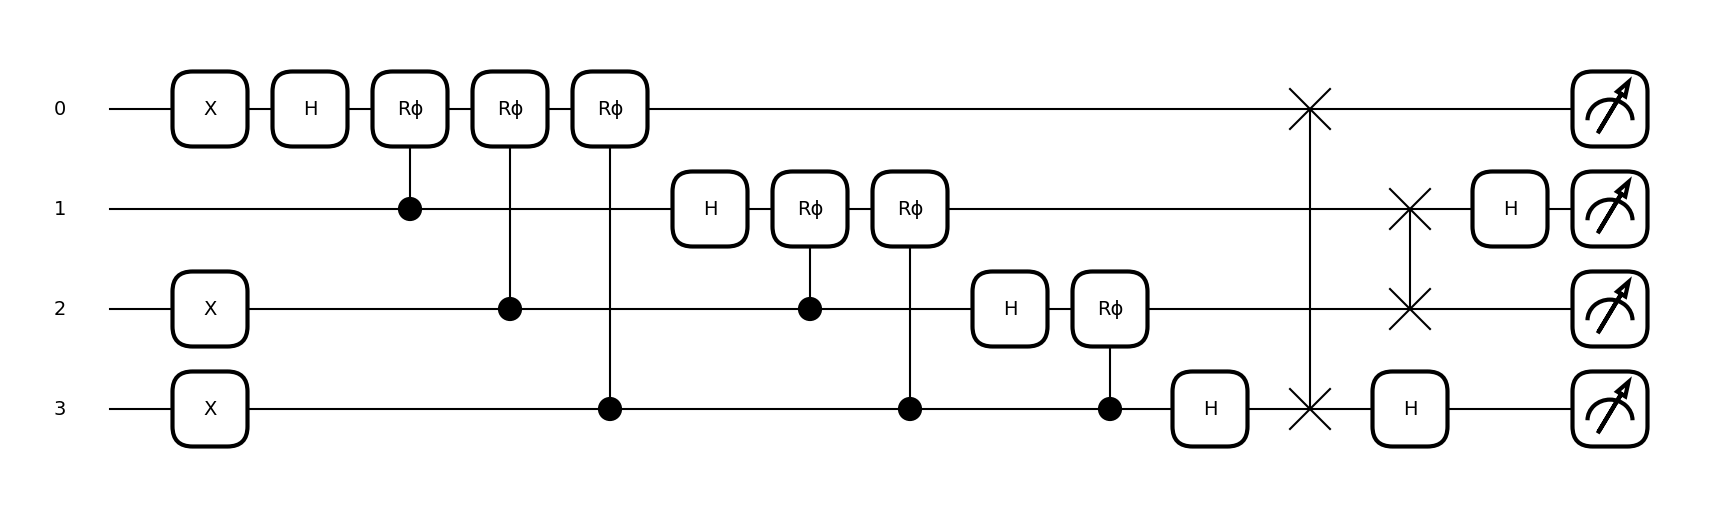

In [7]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

dev = qml.device("default.qubit", wires=4, shots=1000)

def qft(wires):
    n = len(wires)
    for i in range(n):
        qml.Hadamard(wires[i])
        for j in range(i + 1, n):
            angle = np.pi / 2 ** (j - i)
            qml.ControlledPhaseShift(angle, wires=[wires[j], wires[i]])
    for i in range(n // 2):
        qml.SWAP(wires=[wires[i], wires[n - i - 1]])

@qml.qnode(dev)
def circuit():

    qml.BasisState(np.array([1, 0, 1, 1]), wires=range(4))

    qft(wires=[0, 1, 2, 3])

    qml.Hadamard(wires=1)
    qml.Hadamard(wires=3)

    return qml.counts(wires=range(4))

counts = circuit()
qml.draw_mpl(circuit)()

# plt.bar(counts.keys(), counts.values())
# plt.xticks(rotation=90)
# plt.xlabel("Measurement outcomes (qubit 0 = LSB)")
# plt.ylabel("Counts")
# plt.title("Measurement in Z on qubits 0,2 and X on qubits 1,3")
# plt.tight_layout()
# plt.show()


In [8]:
import pennylane as qml
from pennylane import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# 4-qubit device with measurement statistics
dev = qml.device("default.qubit", wires=4, shots=1000)

def qft(wires):
    n = len(wires)
    for i in range(n):
        qml.Hadamard(wires[i])
        for j in range(i + 1, n):
            angle = np.pi / 2 ** (j - i)
            qml.ControlledPhaseShift(angle, wires=[wires[j], wires[i]])
    for i in range(n // 2):
        qml.SWAP(wires=[wires[i], wires[n - i - 1]])

@qml.qnode(dev)
def measure_all():
    # Prepare |1011⟩ where wire 0 is LSB
    qml.BasisState(np.array([1,1,0,1]), wires=range(4))

    # Apply QFT
    qft([0,1,2,3])

    # Measure qubits 1 and 3 (2nd and 4th) in X basis
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=3)

    return qml.sample(wires=[0,1,2,3])  # Measure all qubits in Z basis

# Run circuit and collect samples
samples = measure_all()

# Group by (q1, q3) outcomes in X basis (they were rotated into Z basis)
grouped = defaultdict(list)
for s in samples:
    s = list(s)
    key = (s[1], s[3])  # wires 1 and 3
    value = (s[0], s[2])  # wires 0 and 2
    grouped[key].append(value)

print("\nMarginal probabilities for qubits 1 and 3 (X basis):")
total = len(samples)
for outcome in sorted(grouped):
    count = len(grouped[outcome])
    prob = count / total
    print(f"Outcome (q1, q3) = {outcome} → P = {prob:.3f}")

print("\nPost-measurement distributions of qubits 0 and 2 (Z basis):")
for outcome in sorted(grouped):
    post_vals = grouped[outcome]
    counts = Counter(post_vals)
    total_outcome = sum(counts.values())
    print(f"\nConditioned on (q1, q3) = {outcome}:")
    for post_state, freq in counts.items():
        print(f"    |{post_state[1]}{post_state[0]}⟩ with P = {freq / total_outcome:.3f}")



Marginal probabilities for qubits 1 and 3 (X basis):
Outcome (q1, q3) = (0, 0) → P = 0.353
Outcome (q1, q3) = (0, 1) → P = 0.147
Outcome (q1, q3) = (1, 0) → P = 0.349
Outcome (q1, q3) = (1, 1) → P = 0.151

Post-measurement distributions of qubits 0 and 2 (Z basis):

Conditioned on (q1, q3) = (0, 0):
    |01⟩ with P = 0.235
    |00⟩ with P = 0.263
    |11⟩ with P = 0.218
    |10⟩ with P = 0.283

Conditioned on (q1, q3) = (0, 1):
    |01⟩ with P = 0.272
    |11⟩ with P = 0.231
    |00⟩ with P = 0.224
    |10⟩ with P = 0.272

Conditioned on (q1, q3) = (1, 0):
    |00⟩ with P = 0.264
    |01⟩ with P = 0.252
    |10⟩ with P = 0.264
    |11⟩ with P = 0.221

Conditioned on (q1, q3) = (1, 1):
    |00⟩ with P = 0.225
    |10⟩ with P = 0.252
    |11⟩ with P = 0.311
    |01⟩ with P = 0.212
